# Полносвязные сети



## О задании

Нам предстоит обучить полносвязную нейронную сеть для предсказания года выпуска песни по ее аудио-признакам. Для этого мы будем использовать [Million Songs Dataset](https://samyzaf.com/ML/song_year/song_year.html).

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import random

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

Начнем с того, что скачаем и загрузим данные:

In [ ]:
!wget -O yearpredictionmsd.zip https://archive.ics.uci.edu/static/public/203/yearpredictionmsd.zip

--2025-10-12 21:13:59--  https://archive.ics.uci.edu/static/public/203/yearpredictionmsd.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘yearpredictionmsd.zip’

yearpredictionmsd.z     [                 <=>] 201.24M  62.3MB/s    in 3.3s    

2025-10-12 21:14:02 (60.3 MB/s) - ‘yearpredictionmsd.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('yearpredictionmsd.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Посмотрим на статистики по данным.

In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


Целевая переменная, год выпуска песни, записана в первом столбце. Посмотрим на ее распределение.

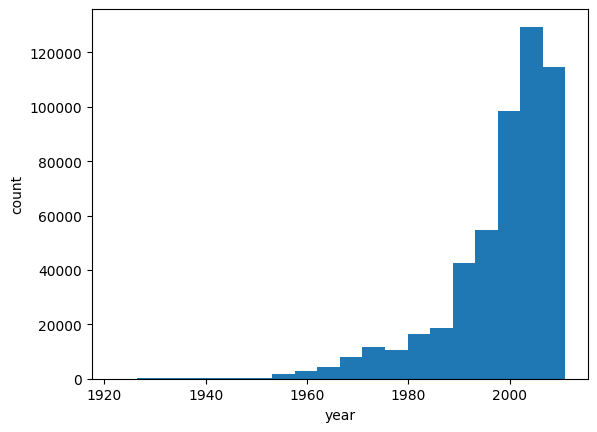

Range: 1922 - 2011
Unique values: 89


In [ ]:
plt.hist(df.iloc[:, 0], bins=20)
plt.xlabel('year')
plt.ylabel('count')
plt.show()
print(f'Range: {df.iloc[:, 0].min()} - {df.iloc[:, 0].max()}')
print(f'Unique values: {np.unique(df.iloc[:, 0]).size}')

Разобьем данные на обучение и тест.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = int(0.75 * X.shape[0])

X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

X_train.shape, X_test.shape

((386508, 90), (128837, 90))

Мы будем использовать RMSE как метрику качества. Прежде чем обучать нейронные сети, нам нужно проверить несколько простых бейзлайнов, чтобы было с чем сравнить более сложные алгоритмы. Для этого обучим `Ridge` регрессию из `sklearn`. Кроме того, посчитаем качество при наилучшем константном прогнозе.



In [ ]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    # также можно зафиксировать seed для Dataloader
    g = torch.Generator()
    g.manual_seed(seed)
    return g

# Сид для каждого worker в Dataloader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = set_global_seed(42)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

model = Ridge()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

rmse_for_model = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_for_model

np.float64(9.47363033268409)

Лучшая константа для RMSE это среднее.

In [ ]:
y_pred = np.array([np.mean(y_train)] * len(y_test))

best_rmse_metric = np.sqrt(mean_squared_error(y_test, y_pred))
best_rmse_metric

np.float64(10.845542969687791)

Теперь приступим к экспериментам с нейросетями. Для начала отделим от данных валидацию. Тестовую выборку мы будем использовать только для того, чтобы измерить итоговую метрику качества модели.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0xE2E4)
X_train.shape, X_val.shape

((289881, 90), (96627, 90))

## Обучаем линейную регрессию

Обучим в `pytorch` линейную регрессию.

Создим модель линейной регрессии, которая будет состоять только из одного `Linear()` слоя.
   

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.model = nn.Linear(in_features=size, out_features=1, bias=True)
    def forward(self, x):
        return self.model(x)

def train(model, epochs):

  train_losses, test_losses = [], []

  for epoch in range(epochs):
    model.train()

    y_pred_train = model(X_train_tensor)
    train_loss = ((y_pred_train - y_train_tensor) ** 2).mean()

    model.zero_grad()
    train_loss.backward()


    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
            param.grad.zero_()


    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        test_loss = ((y_pred_test - y_test_tensor) ** 2).mean()


    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

  return train_losses, test_losses, y_pred_test

In [ ]:
y_scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
y_train_sc = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_sc = y_scaler.transform(y_test.reshape(-1, 1))

X_train_tensor = torch.FloatTensor(X_train_sc)[:10000]
y_train_tensor = torch.FloatTensor(y_train_sc)[:10000].reshape(-1,1)
X_test_tensor = torch.FloatTensor(X_test_sc)[:10000]
y_test_tensor = torch.FloatTensor(y_test_sc)[:10000].reshape(-1,1)

In [ ]:
model = LinearRegression(X_train_tensor.shape[1])
learning_rate = 0.001
epochs = 10
train_losses, test_losses, y_pred_test = train(model, epochs)

(1.284125804901123, 1.3462897539138794)

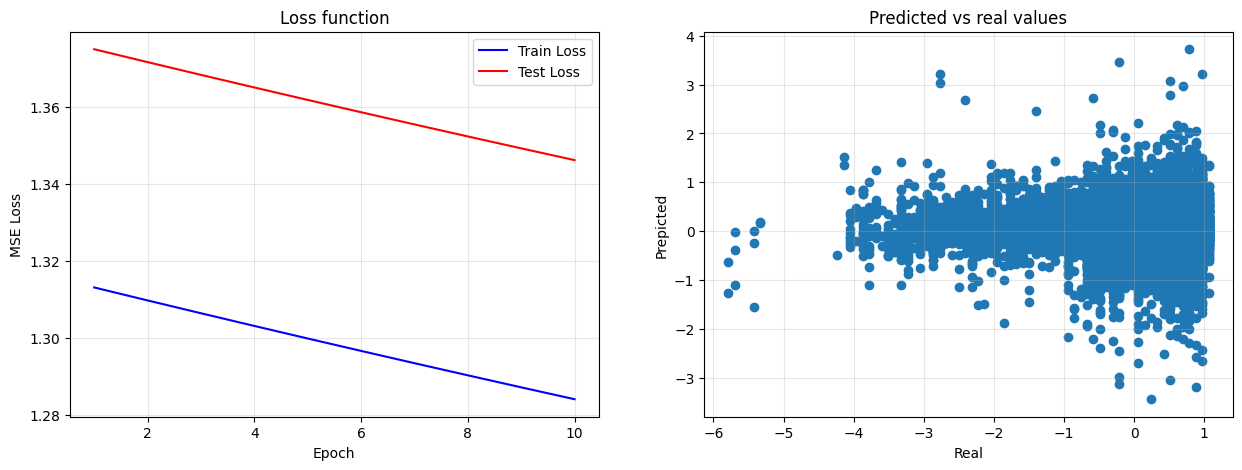

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, 'b', label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, 'r', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss function')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test_tensor.numpy(), y_pred_test.detach().numpy())
plt.xlabel('Real')
plt.ylabel('Prepicted')
plt.title('Predicted vs real values')
plt.grid(True, alpha=0.3)

train_losses[-1], test_losses[-1]

##  Нейронные сети

Ниже нам предстоит реализовать довольно много различных нейросетей и поставить целую серию экспериментов.

In [ ]:
def training_epoch(model, optimizer, criterion, train_loader):
    """Одна эпоха обучения
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
    """

    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    return train_loss / len(train_loader.dataset)

    raise NotImplementedError


@torch.no_grad()
def validation_epoch(model, criterion, val_loader):
    """Одна эпоха валидации модели
    params:
        model - torch.nn.Module to be fitted
        criterion - loss function from torch.nn
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    model.eval()
    running_loss = 0.0
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(val_loader.dataset)

    raise NotImplementedError


@torch.no_grad()
def predict(model, data_loader):
    """ Предсказания модели
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        data_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """

    model.eval()
    predicts = []
    for X_batch, _ in data_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predicts.append(y_pred.cpu())
    return torch.cat(predicts, dim=0)

def train(model, optimizer, criterion, train_loader, val_loader, epochs, class_to_year=None, denormalize=None):
    """ Обучение модели
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        epochs - number of training epochs
    """
    train_losses, val_losses, train_rmse, val_rmse = [], [], [], []

    for epoch in range(epochs):
        train_loss = training_epoch(model, optimizer, criterion, train_loader)
        val_loss = validation_epoch(model, criterion, val_loader)
        rmse_val = compute_rmse(model, val_loader, class_to_year=class_to_year, denormalize=denormalize)
        rmse_train = compute_rmse(model, train_loader, class_to_year=class_to_year, denormalize=denormalize)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_rmse.append(rmse_val)
        train_rmse.append(rmse_train)
    return train_losses, val_losses, train_rmse, val_rmse

    raise NotImplementedError




@torch.no_grad()
def compute_rmse(model, data_loader, class_to_year=None, denormalize=None):
  model.eval()
  preds1, trues1 = [], []
  for X_batch, y_batch in data_loader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      logits = model(X_batch)

      if class_to_year is not None:
        pred_classes = logits.argmax(dim=1).cpu().numpy()
        y_batch = y_batch.cpu().numpy().reshape(-1)

        pred_years = [class_to_year[int(c)] for c in pred_classes]
        true_years = [class_to_year[int(c)] for c in y_batch]

        preds1.append(pred_years)
        trues1.append(true_years)

      else:
        preds1.append(logits.cpu().numpy().reshape(-1))
        trues1.append(y_batch.cpu().numpy().reshape(-1))

  preds = np.concatenate(preds1)
  trues = np.concatenate(trues1)
  if denormalize is not None:
        preds = denormalize(preds)
        trues = denormalize(trues)
  rmse = np.sqrt(np.mean((preds - trues) ** 2))
  return rmse


Попробуем обучить нашу первую нейронную сеть. Здесь целевая переменная дискретная &mdash; это год выпуска песни. Поэтому будем учить сеть на классификацию.



In [ ]:
years = np.unique(np.concatenate([y_train, y_val]))

classes = {years[i]:i for i in range(len(years))}
class_to_year = {i:years[i] for i in range(len(years))}

y_train_classes = np.array([classes[y] for y in y_train])
y_val_classes   = np.array([classes[y] for y in y_val])

In [ ]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train_classes))
val_dataset   = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val_classes))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker, generator=g)

In [ ]:
class Classification(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 128
num_classes = len(years)

model = Classification(input_dim, hidden_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 3
train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs, class_to_year=class_to_year)
train_losses, val_losses

([4.523161391175996, 4.13035493588715, 3.9649871610638536],
 [4.233187972567233, 4.037523880155099, 3.899285286377201])

In [ ]:
train_rmse, val_rmse

([np.float64(13.94400931955499),
  np.float64(13.941832560087656),
  np.float64(13.939690354386862)],
 [np.float64(13.972770608666405),
  np.float64(13.973318316107486),
  np.float64(13.972217694930132)])

RMSE классификационной модели составил около 13–14 лет, что достаточно высоко. Бейзлайн равный 10-11 не был побит(  Это естественно, так как мы обучились всего 3 эпохи, а также CrossEntropyLoss не учитывает расстояние между соседними классами.

Для задачи предсказания года регрессия является более логичным выбором. Она учитывает, что ошибка на 1 год лучше, чем на 10 лет, чего классификация не делает.

Теперь попробуем решать задачу как регрессию. Обучите нейронную сеть на MSE.



In [ ]:
y_train_reg = y_train.reshape(-1, 1)
y_val_reg   = y_val.reshape(-1, 1)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train_reg))
val_dataset   = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val_reg))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker, generator=g)


In [ ]:
class RegressionNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1))

    def forward(self, x):
        return self.model(x)

In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 128

model = RegressionNet(input_dim, hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7)


In [ ]:
train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=3)


In [ ]:
train_losses, val_losses

([3570692.0738277086, 3910190.0487734624, 3951550.354908566],
 [3980972.263303735, 3967011.6299610874, 3952389.2659582724])

In [ ]:
train_rmse, val_rmse

([np.float32(1995.2605), np.float32(1991.738), np.float32(1988.0581)],
 [np.float32(1995.2374), np.float32(1991.7358), np.float32(1988.0618)])

 Обучение без нормализации оказалось нестабильным. При больших значениях learning rate(от 1е-3) нейронка не могла обучиться, не успевала сойтись за 3 эпохи, а при уменьшении lr RMSE получается очень большим (порядка тысячи лет), тк шаг становился очень маленьким.

При замене классификации на регрессию модель дала предсказания, которые напрямую отражают разницу между годами, вместо того чтобы просто угадывать класс. Но года выражаются в тысячах, а признаки нет, поэтому стоит использовать нормализацию.

Начнем с того, что попробуем отнормировать целевую переменную. Для этого воспользуемся min-max нормализацией, чтобы целевая переменная принимала значения от 0 до 1.

In [ ]:
def normalize(sample):
    """
    Min-max normalization to convert sample to [0, 1] range
    """
    return (sample - y_train.min()) / (y_train.max() - y_train.min())

def denormalize(sample):
    """
    Denormalize sample from [0, 1] to initial range
    """
    return sample * (y_train.max() - y_train.min()) + y_train.min()

Также добавим сигмоидную активацию после последнего линейного слоя сети. Таким образом мы гарантируем, что нейронная сеть предсказывает числа из промежутка $[0, 1]$.

In [ ]:
class RegressionNetSigmoid(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
y_train_norm = normalize(y_train.reshape(-1, 1))
y_val_norm   = normalize(y_val.reshape(-1, 1))

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train_norm))
val_dataset   = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val_norm))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker, generator=g)


input_dim = X_train.shape[1]
hidden_dim = 128

model = RegressionNetSigmoid(input_dim, hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

In [ ]:
train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=3, denormalize=denormalize)

In [ ]:
train_losses, val_losses

([415.62398902557635, 0.7729707173149426, 0.45346062052868447],
 [1.1181708305075766, 0.6034808370242241, 0.4426907354766428])

In [ ]:
train_rmse, val_rmse

([np.float64(90.07220883513467),
  np.float64(64.02209035981147),
  np.float64(54.49325892597961)],
 [np.float64(94.11180122493526),
  np.float64(69.138785966189),
  np.float64(59.21615782724683)])

На этот раз попробуем отнормировать не только целевую переменную, но и сами данные, которые подаются сети на вход. Для них будем использовать нормализацию через среднее и стандартное отклонение.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)

train_dataset = TensorDataset(torch.FloatTensor(X_train_sc), torch.FloatTensor(y_train_norm))
val_dataset   = TensorDataset(torch.FloatTensor(X_val_sc), torch.FloatTensor(y_val_norm))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker, generator=g)

model = RegressionNetSigmoid(input_dim=X_train_sc.shape[1], hidden_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 15


In [ ]:
train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs, denormalize=denormalize)


In [ ]:
train_rmse[-1], val_rmse[-1]

(np.float64(9.881530340667524), np.float64(9.927535113649999))

Получилось качество, сравнимое с `Ridge` регрессией.

**Мораль:** как видите, нам пришлось сделать очень много хитрых телодвижений, чтобы нейронная сеть работала хотя бы так же, как и простая линейная модель. Здесь, конечно, показан совсем экстремальный случай, когда без нормализации данных нейронная сеть просто не учится. Как правило, в реальности завести нейронную сеть из коробки не очень сложно, но вот заставить ее работать на полную &mdash; куда более трудоемкая задача. Написание пайплайнов обучения нейросетевых моделей требует большой аккуратности, а дебаг часто превращается в угадайку.

## Улучшаем нейронную сеть
Продолжим экспериментировать с нейронной сетью, чтобы добиться еще лучшего качества.

Попробуем другие оптимизаторы. Обучим нейросеть с помощью SGD+momentum и Adam.

In [ ]:
model = RegressionNetSigmoid(input_dim=X_train_sc.shape[1], hidden_dim=128).to(device)
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer_sgd, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)

In [ ]:
train_rmse, val_rmse

([np.float64(10.141714776510025),
  np.float64(9.849595982247228),
  np.float64(9.678392238194261),
  np.float64(9.557258711509954),
  np.float64(9.46521111033107),
  np.float64(9.393767847355702),
  np.float64(9.336395985511455),
  np.float64(9.289342662512789),
  np.float64(9.249613052695109),
  np.float64(9.215571622056526)],
 [np.float64(10.189977942018873),
  np.float64(9.898456692347404),
  np.float64(9.73183058163028),
  np.float64(9.614316694050926),
  np.float64(9.526608624110668),
  np.float64(9.457882318951432),
  np.float64(9.403125564879321),
  np.float64(9.358882370947752),
  np.float64(9.322788008797454),
  np.float64(9.290471294832285)])

In [ ]:
model = RegressionNetSigmoid(input_dim=X_train_sc.shape[1], hidden_dim=128).to(device)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses, train_rmse, val_rmse= train(model, optimizer_adam, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)


In [ ]:
train_rmse, val_rmse

([np.float64(8.895085591513826),
  np.float64(8.78735310368688),
  np.float64(8.72379216975046),
  np.float64(8.706198244660719),
  np.float64(8.649540235775014),
  np.float64(8.596294125918137),
  np.float64(8.61057720625047),
  np.float64(8.621800827545838),
  np.float64(8.496068853672005),
  np.float64(8.524423070465827)],
 [np.float64(9.018365758651147),
  np.float64(8.93477823145551),
  np.float64(8.891943246785056),
  np.float64(8.907386101435883),
  np.float64(8.866982264322573),
  np.float64(8.843726655649204),
  np.float64(8.893055238667976),
  np.float64(8.89049318719492),
  np.float64(8.798334996529857),
  np.float64(8.86482797198139)])

Оптимайзер Adam показывает лучшие значения как на train, так и на валидации.
Это связано с тем, что Adam адаптивно подбирает скорость обучения для каждого параметра, это позволяет избегать попадания в локальные минимумы.

Теперь сделаем нашу нейронную сеть более сложной.

In [ ]:
class RegressionNetDeep(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model = RegressionNetDeep(input_dim=X_train_sc.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses, train_rmse, val_rmse= train(model, optimizer, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)

In [ ]:
train_rmse, val_rmse

([np.float64(8.90134413525906),
  np.float64(8.728049073730507),
  np.float64(8.578197195548462),
  np.float64(8.49839363507143),
  np.float64(8.404404420177727),
  np.float64(8.355705626936732),
  np.float64(8.263822371994173),
  np.float64(8.18752837056299),
  np.float64(8.126631521814913),
  np.float64(8.055908149841525)],
 [np.float64(9.02226542799594),
  np.float64(8.900907569752704),
  np.float64(8.809299366211675),
  np.float64(8.783546935195359),
  np.float64(8.743751080697848),
  np.float64(8.746018908057943),
  np.float64(8.73741041553397),
  np.float64(8.734763498108318),
  np.float64(8.732052660468593),
  np.float64(8.707195730590751)])

 Увеличение числа параметров позволило модели лучше подстраиваться под тренировочные данные, что выразилось в снижении RMSE на обучении. На валидационной выборке качество улучшилось не так сильно и немного отстает от обучающей, что говорит о начале переобучения, также с увеличением эпох на валидационной выборке ошибка перестает уменьшаться.

Более сложная модель может сильнее переобучаться. Попробуем разные методы регуляризации, чтобы бороться с переобучением. Проведем два эксперимента:

- Добавим слой дропаута с параметром $p=0.2$ после каждого линейного слоя, кроме последнего.
- Попробуем batch-нормализацию вместо дропаута.

In [ ]:
class RegressionNetDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, p=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden_dim2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
model = RegressionNetDropout(input_dim=X_train_sc.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)

In [ ]:
train_rmse[-1], val_rmse[-1]

(np.float64(8.378771368838116), np.float64(8.674054119229773))

In [ ]:
class RegressionNetBatchNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)


In [ ]:
model = RegressionNetBatchNorm(input_dim=X_train_sc.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)

In [ ]:
train_rmse[-1], val_rmse[-1]

(np.float64(8.155057857894613), np.float64(8.745844150807292))

 Оба метода улучшили устойчивость модели по сравнению с предыдущей.

Dropout показал более сбалансированные результаты, тк разница между ошибкой на обучающей и валидационной выборках меньше, что указывает на меньшее переобучение. В то время как Batch Normalization сильнее переобучилась.


 Теперь, когда мы определились с выбором архитектуры нейронной сети, пора заняться рутиной DL-инженера &mdash; перебором гиперпараметров. Подберем оптимальное значение lr по значению RMSE на валидации.Затем оптимальное значение weight decay для данного lr.

In [ ]:
lrs = [1e-4, 3e-4, 1e-3, 3e-3]
rmse_val_lr = []
rmse_train_lr = []

for lr in lrs:
    model = RegressionNetDropout(input_dim=X_train_sc.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)

    rmse_train_lr.append(train_rmse[-1])
    rmse_val_lr.append(val_rmse[-1])


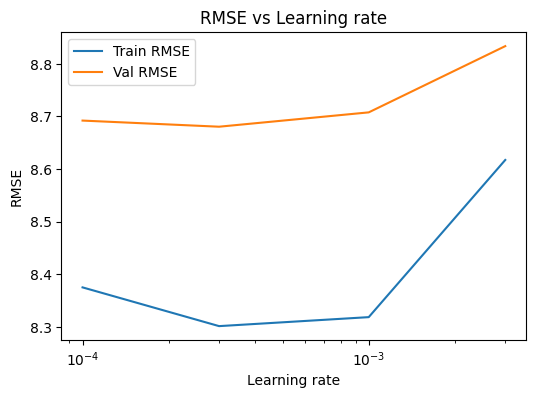

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(lrs, rmse_train_lr, label='Train RMSE')
plt.plot(lrs, rmse_val_lr, label='Val RMSE')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('RMSE')
plt.title('RMSE vs Learning rate')
plt.legend();


Если lerning rate маленький, то модель не успевает прийти к нужно значению, тк обучается медленно, когда lr слишком большой, градиентный шаг может оказаться слишком большим, и модель будет перескакивать через оптимальное значение функции потерь, может и во все не сойтись и обучатся нестабильно.

In [ ]:
weight_decays = [0, 1e-6, 1e-5, 1e-4, 1e-3]
rmse_train_wd, rmse_val_wd = [], []

for wd in weight_decays:
    model = RegressionNetDropout(input_dim=X_train_sc.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=wd)

    train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)

    rmse_train_wd.append(train_rmse[-1])
    rmse_val_wd.append(val_rmse[-1])


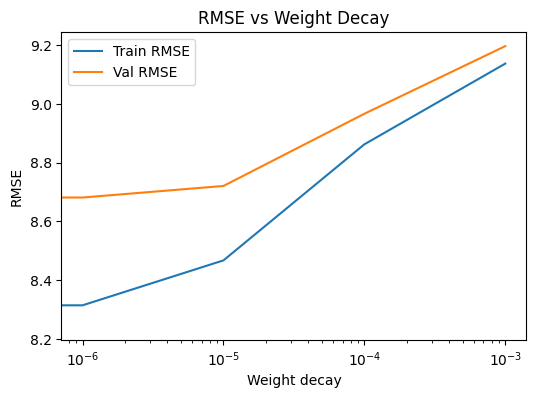

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(weight_decays, rmse_train_wd, label='Train RMSE')
plt.plot(weight_decays, rmse_val_wd, label='Val RMSE')
plt.xscale('log')
plt.xlabel('Weight decay')
plt.ylabel('RMSE')
plt.title('RMSE vs Weight Decay')
plt.legend();


Оптимально брать минимальный Weight decay, тк модель и так не склонна сильно переобучаться и уже есть другие методы регуляризации (Dropout), поэтому не нужно слишком сильно штрафовать за большие веса.

In [ ]:
rmse_train_wd[1], rmse_val_wd[1]

(np.float64(8.314653756416197), np.float64(8.681578835033141))

 В результате такого подбора модель стала меньше переобучаться, это видно по не такой значительной разнице rmse между трайном и валидацией, также показатель на валидации уменьшился.

Теперь продолжим эксперименты!

In [ ]:
X_test_sc = scaler.transform(X_test)
y_test_norm = normalize(y_test.reshape(-1, 1))
test_dataset = TensorDataset(torch.FloatTensor(X_test_sc), torch.FloatTensor(y_test_norm))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker, generator=g)

model = RegressionNetDropout(input_dim=X_train_sc.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)
train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)


test_rmse = compute_rmse(model, test_loader, denormalize=denormalize)
test_rmse

np.float64(8.691787879350843)

Сначала проверим результат на test с подобранными lr и weight_decay из предыдущего задания, результат получился отличный!!

Попробуем сделать другую функцию активации:

In [ ]:
class RegressionNetDropoutELU(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, p=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.LeakyReLU(0.1),
            nn.Dropout(p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.1),
            nn.Dropout(p),
            nn.Linear(hidden_dim2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
model = RegressionNetDropoutELU(input_dim=X_train_sc.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)
train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)


test_rmse = compute_rmse(model, test_loader, denormalize=denormalize)
test_rmse

np.float64(8.684348201257562)

Ошибка стала чуть больше, вероятно, это связано с тем, что для данной архитектуры и нормализованных данных подходит более простая функция ReLU.

Попробуем подобрать лучший параметр $p$ для дропаута:

In [ ]:
dropouts = [0.1, 0.2, 0.4]
results = {}

for p in dropouts:
  model = RegressionNetDropout(input_dim=X_train_sc.shape[1], p=p).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)
  train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)

  results[p] = (train_rmse[-1], val_rmse[-1])


for p, (tr, vl) in results.items():
    print(f"p={p}: Train={tr:.4f}, Val={vl:.4f}")


p=0.1: Train=8.1065, Val=8.6260
p=0.2: Train=8.2862, Val=8.6558
p=0.4: Train=8.5356, Val=8.7445


Можно заметить, что наименьшее значение на валидации получилось при p = 0.1, проверим это значение на тесте, есть вероятность, что модель может переобучиться, тк разница ошибок с трейном большая.

In [ ]:
model = RegressionNetDropout(input_dim=X_train_sc.shape[1], p=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)
train_losses, val_losses, train_rmse, val_rmse = train(model, optimizer, criterion, train_loader, val_loader, epochs=10, denormalize=denormalize)

test_rmse = compute_rmse(model, test_loader, denormalize=denormalize)
test_rmse


np.float64(8.746749671766766)

Значение стало сильно хуже, это подтверждает переобучение.